## Линейные модели или решающие деревья?

Раньше мы разбирали только линейные модели, которые имеют совсем другую природу по отношению к решающим деревьям. Можно ли сказать, что какой-то из этих двух типов моделей всегда лучше? Нет. В зависимости от пространственной структуры данных один из них будет работать лучше:

- Линейная модель, если данные хорошо линейно разделимы.

- Решающие деревья, если данные плохо линейно разделимы (присутствуют только кусочно-линейные или нелинейные зависимости).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


%matplotlib inline
plt.rcParams["figure.figsize"] = (11, 6.5)

Посмотрим на линейно разделимую выборку.

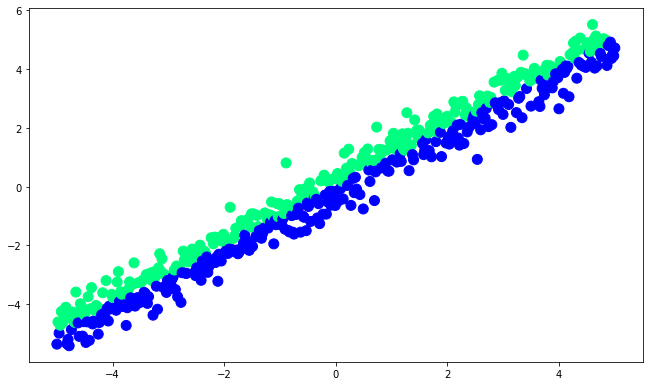

In [ ]:
np.random.seed(13)
n = 500
X = np.zeros(shape=(n, 2))
X[:, 0] = np.linspace(-5, 5, 500)
X[:, 1] = X[:, 0] + 0.5 * np.random.normal(size=n)
y = (X[:, 1] > X[:, 0]).astype(int)
plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap="winter")
plt.show()

Обучим линейную модель (логистическую регрессию).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

accuracy_score(y_pred_lr, y_test)

0.992

Нарисуем разделяющую поверхность модели. Для визуализации разделяющей поверхности будем использовать функцию plot_decision_regions из библиотеки mlxtend. Это удобный метод для визуализации разделяющей поверхности и областей принадлежности каждого класса.

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


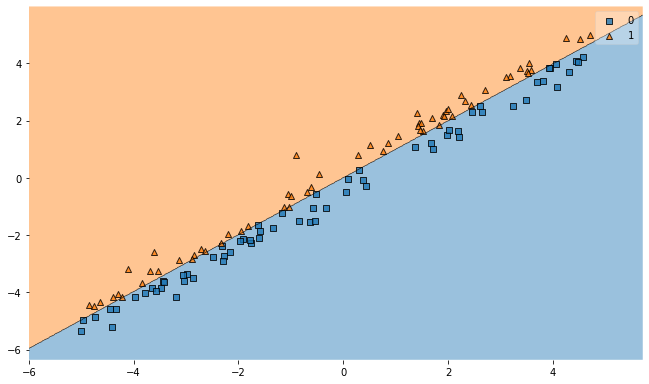

In [ ]:
# !pip install mlxtend

from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X_test, y_test, lr)

plt.show()

Теперь обучим решающее дерево и нарисуем его разделяющую поверхность.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

accuracy_score(y_pred_dt, y_test)

0.872

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


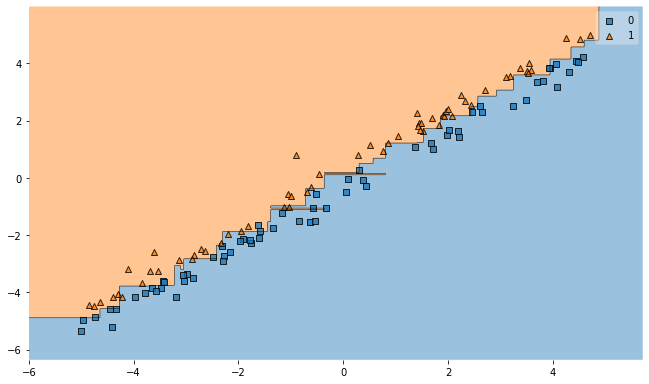

In [ ]:
plot_decision_regions(X_test, y_test, dt)
plt.show()

Видно, что на границах области определения данных разделяющая граница идёт не как наклонная линия, а обрубается горизонтальными и вертикальными прямыми.

То есть если взять данные вне области определения (выходящие за эти границы), то дерево будет предсказывать очень плохо, потому что оно не выучило истинную зависимость ответа от признаков, а подогналось под данные.

Теперь сравним поведение линейной модели и дерева на кусочно-линейных данных.

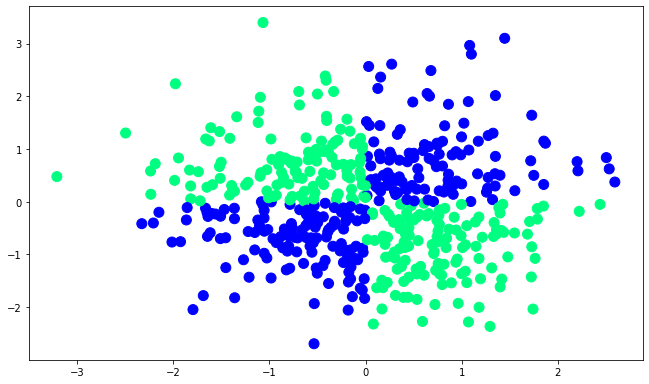

In [ ]:
np.random.seed(13)
X = np.random.randn(500, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)
plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap="winter")
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

accuracy_score(y_pred_lr, y_test)

0.352

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


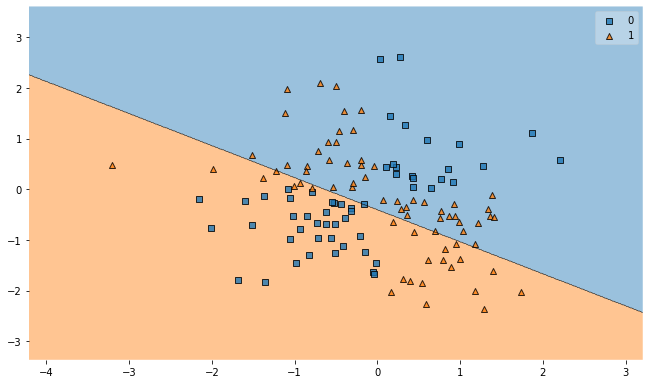

In [ ]:
plot_decision_regions(X_test, y_test, lr)
plt.show()

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

accuracy_score(y_pred_dt, y_test)

1.0

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


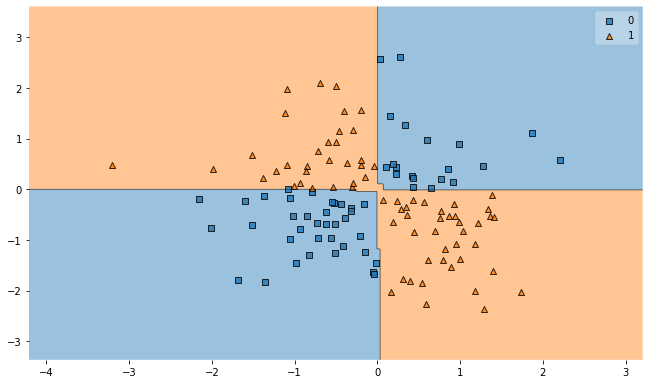

In [ ]:
plot_decision_regions(X_test, y_test, dt)
plt.show()

Мы видим, что в этом случае дерево подошло гораздо лучше, чем линейная модель, из-за отсутствия в данных линейной структуры.

|

|

|

|

|

|

|

|

## Переобучение

Вы уже знаете, что решающие деревья способны переобучиться под любую выборку, если их никак не регуляризовать: при большом количестве листьев для каждого объекта может выделиться своя область в признаковом пространстве. По сути, дерево просто выучивает обучающую выборку, но не выделяет никаких закономерностей среди данных. 

Посмотрим на этот эффект на реальных данных и попробуем его уменьшить.

Будем решать задачу классификации на примере известного датасета о цветках ирисов.


В этом датасете каждый объект (цветок) имеет четыре числовые характеристики: 
*    длина и ширина лепестка;
*    длина и ширина чашелистика.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import load_iris

data = load_iris(as_frame=True)

X = data.data[['sepal length (cm)', 'sepal width (cm)']]
y = data.target

In [ ]:
X.head()

,sepal length (cm),sepal width (cm)
0,5.1,3.5
1,4.9,3.0
2,4.7,3.2
3,4.6,3.1
4,5.0,3.6


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

In [ ]:
tree.get_depth()

10

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))

0.95 0.6666666666666666


Мы видим, что accuracy на обучающих данных очень большая, при этом на тестовых — сильно ниже. Наблюдаем сильное переобучение.

Используем прунинг для уменьшения количества вершин в дереве и, следовательно, для снижения переобучения.

Прунинг при обучении дерева использует регуляризованный функционал:
$$Q_{\alpha}(T) = Q(T) + \alpha |T|,$$
где $T$ — дерево, $Q(T)$ — функция потерь, $|T|$ — число вершин в дереве.

В sklearn есть Cost-Complexity Pruning, который возвращает список возможных порогов $\alpha$ при построении дерева (так как данных конечное число, не нужно рассматривать бесконечное число значений).

In [ ]:
path = tree.cost_complexity_pruning_path(X_train, y_train)
alphas = path['ccp_alphas']

alphas

array([0.        , 0.00277778, 0.00277778, 0.00277778, 0.00324074,
       0.00518519, 0.00555556, 0.00694444, 0.00743464, 0.01006944,
       0.01041667, 0.01161038, 0.01230159, 0.01581699, 0.02010944,
       0.05683866, 0.06089286, 0.20756944])

Чем больше $\alpha$, тем сильнее регуляризация и тем меньше дерево переобучается.

Посмотрим на зависимость качества предсказания дерева на тренировочных и тестовых данных в зависимости от $\alpha$.

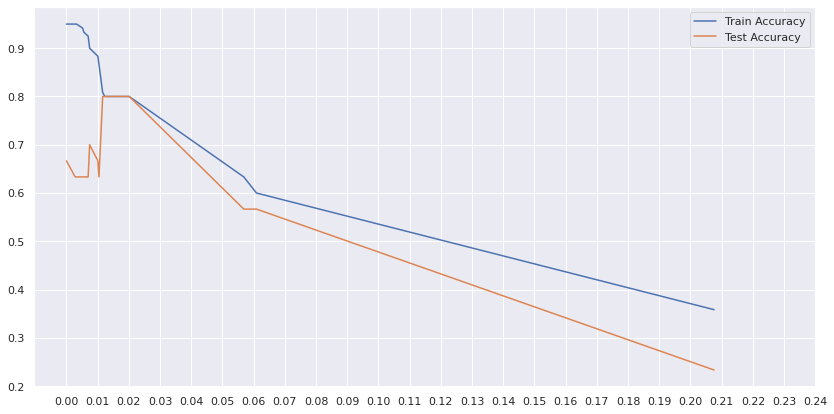

In [ ]:
accuracy_train, accuracy_test=[], []

for i in alphas:
    tree = DecisionTreeClassifier(ccp_alpha = i)

    tree.fit(X_train, y_train)
    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)

    accuracy_train.append(accuracy_score(y_train, y_train_pred))
    accuracy_test.append(accuracy_score(y_test, y_test_pred))

sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y = accuracy_train, x = alphas, label = "Train Accuracy")
sns.lineplot(y = accuracy_test, x = alphas, label = "Test Accuracy")
plt.xticks(ticks = np.arange(0.00,0.25,0.01))
plt.show()

Мы видим, что при регуляризации с $\alpha\in[0.01;0.02]$ получаем наилучшее качество на тестовых данных.

То есть прунинг действительно помогает справиться с переобучением и повысить предсказательную способность дерева.

Посчитаем метрики на трейне и тесте для $\alpha=0.02$.

In [ ]:
tree = DecisionTreeClassifier(ccp_alpha = 0.02, random_state=40)
tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

print(accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))

0.8 0.8


Итак, при помощи прунинга удалось значительно снизить переобучение дерева и повысить качество предсказания на тестовых данных.